# PyTorch Custom Datasets
Reference book --> https://www.learnpytorch.io/04_pytorch_custom_datasets/

We've used the datasets which PyTorch provides, but how to use our own data for training and testing? Let's find out

## Domain Libraries
Depending on what kind problem we're working on, text, audio, vision, recommendation, we'll look into PyTorch domain libraries for existing data loading functions and customizable data loading functions.

We're working on a vision problem, so we'll be checking out the custom data loading functions for `torchvision`.

## 0. Importing PyTorch and setting up device agnostic code


In [ ]:
import torch
from torch import nn

torch.__version__

'2.2.1+cu121'

In [ ]:
# Setup device agnostic code
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
device

device(type='cpu')

In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


## 1. Get Data
Our dataset is the subset of Food101 dataset.

Food101 has 101 different classes of food and 1000 images per class. (750 testing, 250 training).

Our dataset has only 3 classes of images and 10% of the data (75 testing images, 25 training images). We're doing this to speed up our experiments as larger dataset would take too long for computation.

In [ ]:
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder.
data_path = Path('data/')
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download and unzip
if image_path.is_dir():
  print(f'{image_path} already exists... Skipping Download.')
else:
  print(f'{image_path} does not exist. Creating directory...')
  image_path.mkdir(parents=True, exist_ok=True)

  # Download pizza, steak, sushi data, wb=write binary
  with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading pizza, steak, sushi data...")
    f.write(request.content)

  # Unzip pizza, steak, sushi data, r=read mode.
  with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi data...")
    zip_ref.extractall(image_path)

data/pizza_steak_sushi does not exist. Creating directory...
Unzipping pizza, steak, sushi data...


## 2. Becoming one with the data (data preparation and exploration)

In [ ]:
import os
def walk_through_dir(dir_path):
  """
  Walks through dir path returning it's contents.
  """

  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")


In [ ]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.


We have PyTorch's [`torchvision.datasets.ImageFolder`](https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html) which we're going to use to load our data. So, our data is to be stored in the format mentioned in the documentation.

In [ ]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visualizing an image

What we have to do:
1. Get all of the image paths
2. Pick a random image path using Python's random.choice()
3. Get the image class name from `pathlib.Path.parent.stem`
4. Let's open the image from python's image library `PIL`
5. Show the image and print metadata

data/pizza_steak_sushi/test/pizza/2871261.jpg
pizza
Random image path: data/pizza_steak_sushi/test/pizza/2871261.jpg
Image class: pizza
Image height: 384
Image width: 512


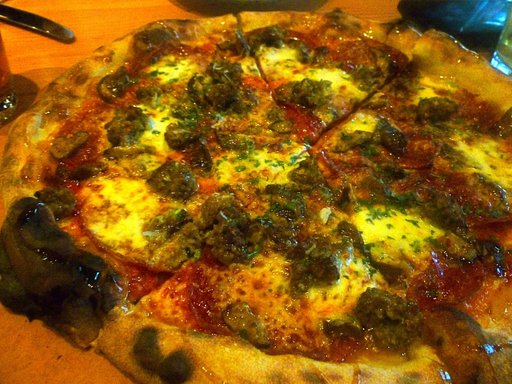

In [ ]:
import random
from PIL import Image

# Set seed
# random.seed(42)

# 1. Get all image paths
image_path_list = list(image_path.glob('*/*/*.jpg'))

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)
print(random_image_path)

# 3. Get image class from path name (the img class is name of directory in which it's stored)
image_class = random_image_path.parent.stem
print(image_class)

# 4. Open Image
img = Image.open(random_image_path)

# 5. Print metadata
print(f'Random image path: {random_image_path}')
print(f'Image class: {image_class}')
print(f'Image height: {img.height}')
print(f'Image width: {img.width}')
img

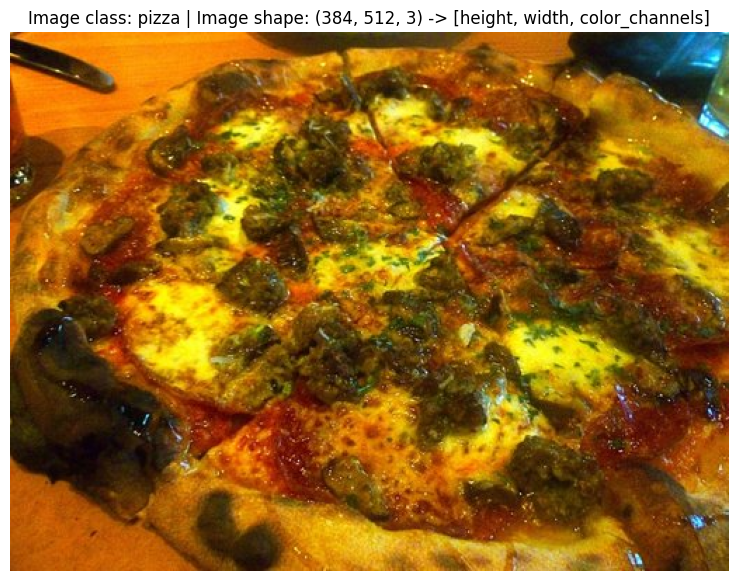

In [ ]:
# Try to visualize the image with matplotlib.
import matplotlib.pyplot as plt
import numpy as np

# Turn the image into array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10,7))
plt.imshow(img)
plt.title(f'Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]')
plt.axis(False);

array([[[214, 150,  63],
        [189, 123,  39],
        [162,  90,  14],
        ...,
        [162, 255, 255],
        [156, 254, 255],
        [123, 220, 226]],

       [[164,  98,  14],
        [154,  86,   3],
        [140,  67,   0],
        ...,
        [ 59, 158, 177],
        [ 69, 166, 175],
        [ 65, 160, 164]],

       [[136,  68,   0],
        [145,  74,   0],
        [149,  72,   0],
        ...,
        [  9, 102, 119],
        [ 20, 110, 119],
        [ 28, 117, 121]],

       ...,

       [[156,  75,  10],
        [153,  72,   7],
        [156,  73,   7],
        ...,
        [117,  88,  22],
        [115,  85,  15],
        [100,  70,   0]],

       [[152,  71,   6],
        [155,  74,   9],
        [159,  76,  10],
        ...,
        [111,  81,  17],
        [115,  86,  16],
        [107,  79,   6]],

       [[139,  58,   0],
        [152,  71,   6],
        [160,  77,  11],
        ...,
        [ 98,  68,   4],
        [108,  79,  11],
        [109,  81,   8]]], dtype=uint8)
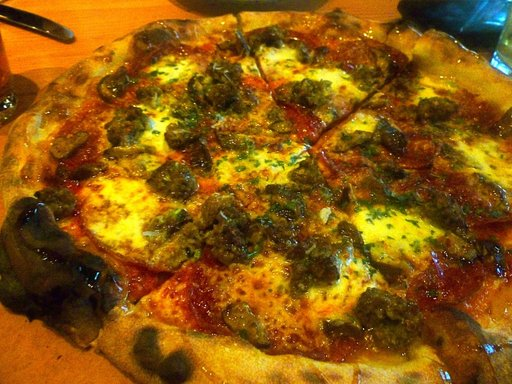

In [ ]:
img_as_array

## 3. Transforming data

Before we can use our image data with PyTorch -
1. Turn your target data into tensors (in our case, numerical representation of our images).
2. Turn it into a `torch.utils.data.Dataset` and subsequently into `torch.utils.data.DataLoader`

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# 3.1 Transforming data with `torchvision.transforms`

Transforms help you get your images ready to work with the model. They also help with data augmentation.
[`torchvision.transforms`](https://pytorch.org/vision/stable/transforms.html) documentation.

In [34]:
# Write a transform for image
data_transform = transforms.Compose([
    # Resize our images to same size
    transforms.Resize(size=(64, 64)),
    # Flip the images randomly on the horizontal (augmentation)
    transforms.RandomHorizontalFlip(p=0.5),  # Flips img 50% of times
    transforms.ToTensor()
])

In [35]:
data_transform(img).shape, data_transform(img).dtype

(torch.Size([3, 64, 64]), torch.float32)

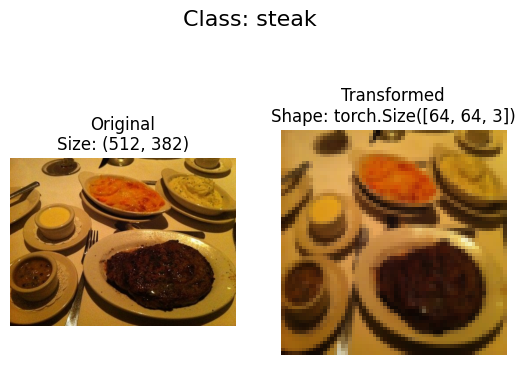

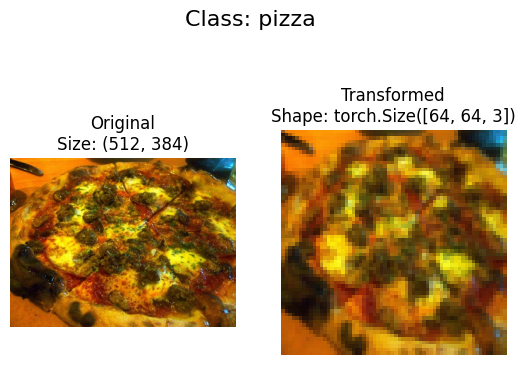

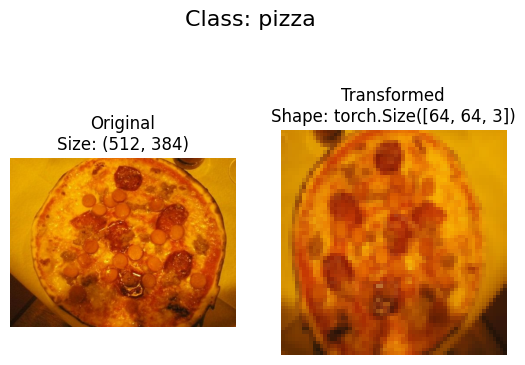

In [36]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
  """
  Selects random images from a path of images and loads/transforms
  them then plots the original vs transformed version.
  """

  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f'Original\nSize: {f.size}')
      ax[0].axis(False)

      # Transform and plot target image
      # This throws errror. # matplotlib expects height, width, color channels. This is channels, height, width.
      # transformed_image = transform(f)
      transformed_image = transform(f).permute(1, 2, 0) # Changes to HWC.
      ax[1].imshow(transformed_image)
      ax[1].set_title(f'Transformed\nShape: {transformed_image.shape}')
      ax[1].axis('off')

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths = image_path_list,
                        transform = data_transform,
                        n=3,
                        seed=42)